RNN With Attention mechanism

In [14]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import numpy as np 
import torch.optim as optim
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import warnings 
warnings.filterwarnings("ignore")

In [15]:
def get_fib_seq(n,scaled_data=True):
    seq = np.zeros(n)

    fib_n1 = 0.0
    fib_n = 1.0

    for i in  range(n):
        seq[i] = fib_n1 + fib_n
        fib_n1 = fib_n
        fib_n = seq[i]
    
    scaler = MinMaxScaler(feature_range=(0,1)) if scaled_data else None
    if scaled_data:
        seq = scaler.fit_transform(seq.reshape(-1,1)).flatten()
    
    return seq ,scaler

In [16]:
def get_fib_XY(total_fib_numbers, time_step, train_percent, scaled_data=True):
    dat, scaler = get_fib_seq(total_fib_numbers, scaled_data)
    Y_ind = np.arange(time_step, len(dat), 1)
    

    Y = dat[Y_ind]
    rows_x = len(Y_ind)
    print("ROWS_X \n", rows_x, "\n")

    X = np.array([dat[i:rows_x + i] for i in range(time_step)]).T

    rand = np.random.RandomState(seed=13)
    idx = rand.permutation(rows_x)
    
    split = int(train_percent * rows_x)

    train_ind, test_ind = idx[:split], idx[split:]
    trainX = X[train_ind]
    trainY = Y[train_ind]
    testX = X[test_ind]
    testY = Y[test_ind]
    
  
    trainX = trainX.reshape(-1, time_step, 1)
    testX = testX.reshape(-1, time_step, 1)
    

    trainX = torch.tensor(trainX, dtype=torch.float32)
    trainY = torch.tensor(trainY, dtype=torch.float32)
    testX = torch.tensor(testX, dtype=torch.float32)
    testY = torch.tensor(testY, dtype=torch.float32)

    print(f"TrainX{trainX.shape} \n TrainY{trainY.shape}")
    
    return trainX, trainY, testX, testY


Attention_mechanism

In [17]:
class Attention(nn.Module):
    def __init__(self,input_dim):
        super(Attention,self).__init__()

        # attention weight and bias
        self.attention_weight = nn.Parameter(torch.rand(input_dim,1))
        self.attention_bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        e = torch.tanh(torch.matmul(x, self.attention_weight) + self.attention_bias)
        e = e.squeeze(-1)

        # Compute the weights
        alpha = F.softmax(e, dim=1)
        alpha = alpha.unsqueeze(-1)

        # Compute the context vector
        context = torch.mul(x, alpha)
        context = torch.sum(context, dim=1)
        return context

In [18]:
class RNNWithAttention(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(RNNWithAttention,self).__init__()

        self.rnn = nn.RNN(input_size,hidden_size,batch_first=True)
        # defining attention layer we coded
        self.attention = Attention(hidden_size)
        self.fc = nn.Linear(hidden_size,output_size)

    
    def forward(self, x):
        rnn_out ,_ = self.rnn(x)
        context = self.attention(rnn_out)
        output = self.fc(context)
        return output


In [19]:
time_steps = 20
hidden_size = 2
epochs = 30
train_percent = 0.8
total_fib_numbers = 1200

trainX,trainY,testX,testY = get_fib_XY(total_fib_numbers,time_steps,train_percent)
model = RNNWithAttention(input_size=1,hidden_size=hidden_size,output_size=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)


for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for i  in tqdm(range(len(trainX)),desc=f"EPOCH {epoch + 1}/{epochs}"):
        optimizer.zero_grad()
        outputs = model(trainX[i].unsqueeze(0)) # adding batch dimension
        loss = criterion(outputs,trainY[i].unsqueeze(0))

        loss.backward()
        optimizer.step() 

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(trainX):.4f}")

# Evaluation
model.eval()
train_mse = criterion(model(trainX), trainY).item()
test_mse = criterion(model(testX), testY).item()

print("Test set MSE =", test_mse)
print("Train set MSE =", train_mse)

ROWS_X 
 1180 

TrainXtorch.Size([944, 20, 1]) 
 TrainYtorch.Size([944])


EPOCH 1/30: 100%|██████████| 944/944 [00:00<00:00, 1010.65it/s]


Epoch [1/30], Loss: 0.0062


EPOCH 2/30: 100%|██████████| 944/944 [00:00<00:00, 1009.00it/s]


Epoch [2/30], Loss: 0.0013


EPOCH 3/30: 100%|██████████| 944/944 [00:00<00:00, 1029.11it/s]


Epoch [3/30], Loss: 0.0013


EPOCH 4/30: 100%|██████████| 944/944 [00:00<00:00, 1004.38it/s]


Epoch [4/30], Loss: 0.0013


EPOCH 5/30: 100%|██████████| 944/944 [00:00<00:00, 1039.39it/s]


Epoch [5/30], Loss: 0.0013


EPOCH 6/30: 100%|██████████| 944/944 [00:00<00:00, 1048.98it/s]


Epoch [6/30], Loss: 0.0013


EPOCH 7/30: 100%|██████████| 944/944 [00:00<00:00, 1049.51it/s]


Epoch [7/30], Loss: 0.0013


EPOCH 8/30: 100%|██████████| 944/944 [00:00<00:00, 1040.14it/s]


Epoch [8/30], Loss: 0.0013


EPOCH 9/30: 100%|██████████| 944/944 [00:00<00:00, 1049.29it/s]


Epoch [9/30], Loss: 0.0013


EPOCH 10/30: 100%|██████████| 944/944 [00:00<00:00, 1020.89it/s]


Epoch [10/30], Loss: 0.0013


EPOCH 11/30: 100%|██████████| 944/944 [00:00<00:00, 1050.89it/s]


Epoch [11/30], Loss: 0.0013


EPOCH 12/30: 100%|██████████| 944/944 [00:00<00:00, 1035.67it/s]


Epoch [12/30], Loss: 0.0013


EPOCH 13/30: 100%|██████████| 944/944 [00:00<00:00, 1018.14it/s]


Epoch [13/30], Loss: 0.0013


EPOCH 14/30: 100%|██████████| 944/944 [00:00<00:00, 1023.31it/s]


Epoch [14/30], Loss: 0.0013


EPOCH 15/30: 100%|██████████| 944/944 [00:00<00:00, 1038.61it/s]


Epoch [15/30], Loss: 0.0013


EPOCH 16/30: 100%|██████████| 944/944 [00:00<00:00, 1035.49it/s]


Epoch [16/30], Loss: 0.0013


EPOCH 17/30: 100%|██████████| 944/944 [00:00<00:00, 1036.49it/s]


Epoch [17/30], Loss: 0.0013


EPOCH 18/30: 100%|██████████| 944/944 [00:00<00:00, 997.51it/s] 


Epoch [18/30], Loss: 0.0013


EPOCH 19/30: 100%|██████████| 944/944 [00:00<00:00, 1038.46it/s]


Epoch [19/30], Loss: 0.0013


EPOCH 20/30: 100%|██████████| 944/944 [00:00<00:00, 1046.51it/s]


Epoch [20/30], Loss: 0.0013


EPOCH 21/30: 100%|██████████| 944/944 [00:00<00:00, 1049.27it/s]


Epoch [21/30], Loss: 0.0013


EPOCH 22/30: 100%|██████████| 944/944 [00:00<00:00, 1045.15it/s]


Epoch [22/30], Loss: 0.0013


EPOCH 23/30: 100%|██████████| 944/944 [00:00<00:00, 1046.81it/s]


Epoch [23/30], Loss: 0.0013


EPOCH 24/30: 100%|██████████| 944/944 [00:00<00:00, 1046.04it/s]


Epoch [24/30], Loss: 0.0013


EPOCH 25/30: 100%|██████████| 944/944 [00:00<00:00, 1052.07it/s]


Epoch [25/30], Loss: 0.0013


EPOCH 26/30: 100%|██████████| 944/944 [00:00<00:00, 1049.27it/s]


Epoch [26/30], Loss: 0.0013


EPOCH 27/30: 100%|██████████| 944/944 [00:00<00:00, 1048.77it/s]


Epoch [27/30], Loss: 0.0013


EPOCH 28/30: 100%|██████████| 944/944 [00:00<00:00, 1023.24it/s]


Epoch [28/30], Loss: 0.0013


EPOCH 29/30: 100%|██████████| 944/944 [00:00<00:00, 1016.03it/s]


Epoch [29/30], Loss: 0.0012


EPOCH 30/30: 100%|██████████| 944/944 [00:00<00:00, 1038.64it/s]

Epoch [30/30], Loss: 0.0012
Test set MSE = 0.0016258826944977045
Train set MSE = 0.0013212788617238402


![Screenshot from 2024-11-09 17-13-55.png](<attachment:Screenshot from 2024-11-09 17-13-55.png>)



the  input to  the attention  should be hidden size not the input_size  it needs to be of proper dimension  for  matrix multiplication 

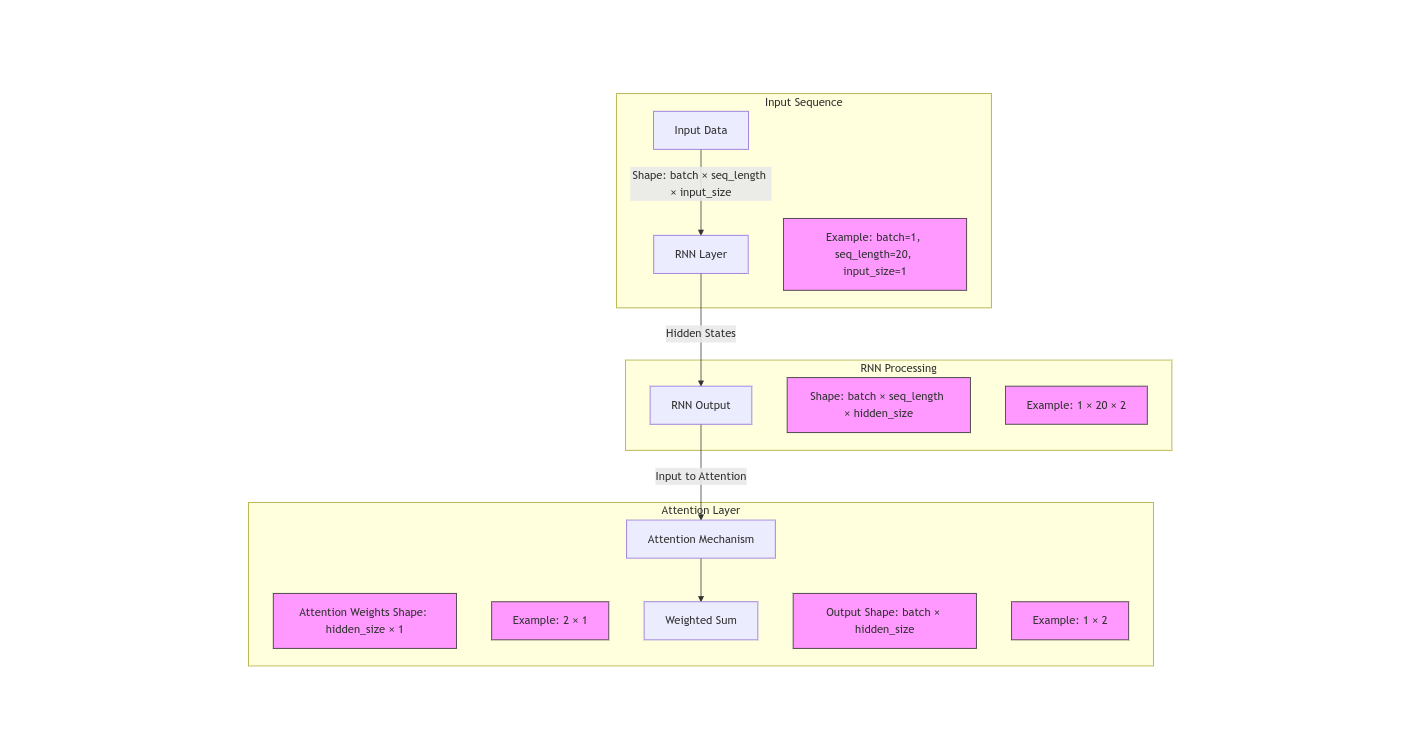